# An automated workflow to reveal potential fraudulent activity in music streaming services

## Outline of the approach 

The objective is to build a classifier to identify accounts likely belonging to bots   
But to do that we need first labels to define categories: human user / bot  
To create the labels one could look for potential 'red flags'/giveaways. And combine those creating a scoring method to measure the likelihood of an account being a bot      
Then, the following step would involve using the scoring method to select a subset of users that are likely bots and a subset of users likely humans.   
These labeled user accounts are then combined it into a train dataset  
And finally Build some classifiers SVD, DecisionTrees, ANN, ... and apply on the test dataset (users)  

The whole data collection, processing and generation of results is orchestrated using Apache Airflow. The workflow is contained in pipeline.py :   
1st the data is downloaded and unzipped using functions in **fetch.py**   
Next the data from 'streams', 'users' and 'tracks' is read and processed with functions in **preprocess.py**  
Finally the results, predicting potential fraudulent user activity is done with **classifier.py**  

In [6]:
import os
import numpy as np
import pandas as pd
import ast
import collections
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

#### Read the data from 'streams', 'users' and 'tracks'

In [7]:
def read_data(filename):
	'''
	reads the contents of streams, tracks and users into a list of dictionaries
	and returns a pandas dataframe
	'''

	lod = [] #list of dictionaries

	with open(filename) as f:
		for line in f:
			lod.append(ast.literal_eval(line))

	return pd.DataFrame(lod)

In [8]:
tracks = read_data('tracks')
users = read_data('users')
streams = read_data('streams')

### Find some parameters based on Normalized Frequency of Streams (per 'country', 'os', 'access'):

This was motivated by the fact that the users in top of stream_counts   
Eg. users[users.user_id == '8ec3584b7ef681f6b817c6b2a5b54153011d7efa']   
come mainly from a couple of countries. Interesting  
Now sorting the user accounts by number of streams doesn't really prove anything  
But maybe some insights can be acquired   
Wait, there might be real human users from one country that are just very heavy users. Yes  
But one could **normalize** the frequency in the top n to the frequency in a random background of n streams  


In [9]:

def nfsc(streams, group_by, top_n):

	'''
	Normalized Frequency of Stream Counts: nfsc
	group_by is one of ['country', 'os', 'access']
	Get frequencies of streams per ['country', 'os', 'access'] in the top_n stream counts 
	and normalize it to the background (random n) streams
	'''
	#stream_counts = streams.groupby(['user_id', 'track_id']).size().reset_index(name='counts')
	#stream_counts.sort_values(by='counts', ascending=False)

	#Get the top n users in stream_counts:
	top_streams_users = stream_counts.sort_values(by='counts', ascending=False).head(top_n).user_id
	#And get the country/os/access of those users
	top_streams_users_grouped = [streams[streams.user_id == u][group_by].values[0] for u in top_streams_users]

	plt.figure(figsize=(20,12))
	#ax = sb.distplot(top_streams_users_countries, bins=len(list(set(users.country))), kde=False)
	ax = sb.countplot(top_streams_users_grouped)
	plt.xlabel(group_by)
	plt.title('%s for the Top %s streams'%(group_by, top_n))
	plt.savefig('plots/%s_for_top_%s_streams.png'%(group_by, top_n))
	#plt.show()

	#rand_streams_users_grouped = [users[users.user_id == u].country.values[0] for u in streams.sample(top_n).user_id]
	rand_streams_users_grouped = [streams[streams.user_id == u][group_by].values[0] for u in streams.sample(top_n).user_id]

	plt.figure(figsize=(20,12))
	#sb.distplot(rand1000_streams_users_countries, bins=users.country.max(), kde=False)
	ax = sb.countplot(rand_streams_users_grouped)
	plt.xlabel(group_by)
	plt.title('%s for a random sample of %s streams'%(group_by,top_n))
	#plt.show()
	plt.savefig('plots/%s_for_rand_%s_streams.png'%(group_by,top_n))


	#Normalize frequency in top1000 to freq in rand1000
	freq_top = collections.Counter(top_streams_users_grouped)
	freq_rand = collections.Counter(rand_streams_users_grouped)

	nfsc = {}
	#if nfsc > 1 :  the group(e.g. country) is 'over-represented' in the top1000 streams compared to the background rand1000
	#if nfsc == 1:  equal frequency in the top1000 and rand1000
	#if nfsc < 1 :  the frequency of the country in the top1000 streams is more or less random

	for i in list(set(streams[group_by])):
		f_top   = freq_top[i]  / float(top_n)
		f_rand  = freq_rand[i] / float(top_n)
		try:
			nfsc[i] = f_top / f_rand
		except ZeroDivisionError:
			nfsc[i] = 1.0

	return nfsc


### Illustrate this with an example

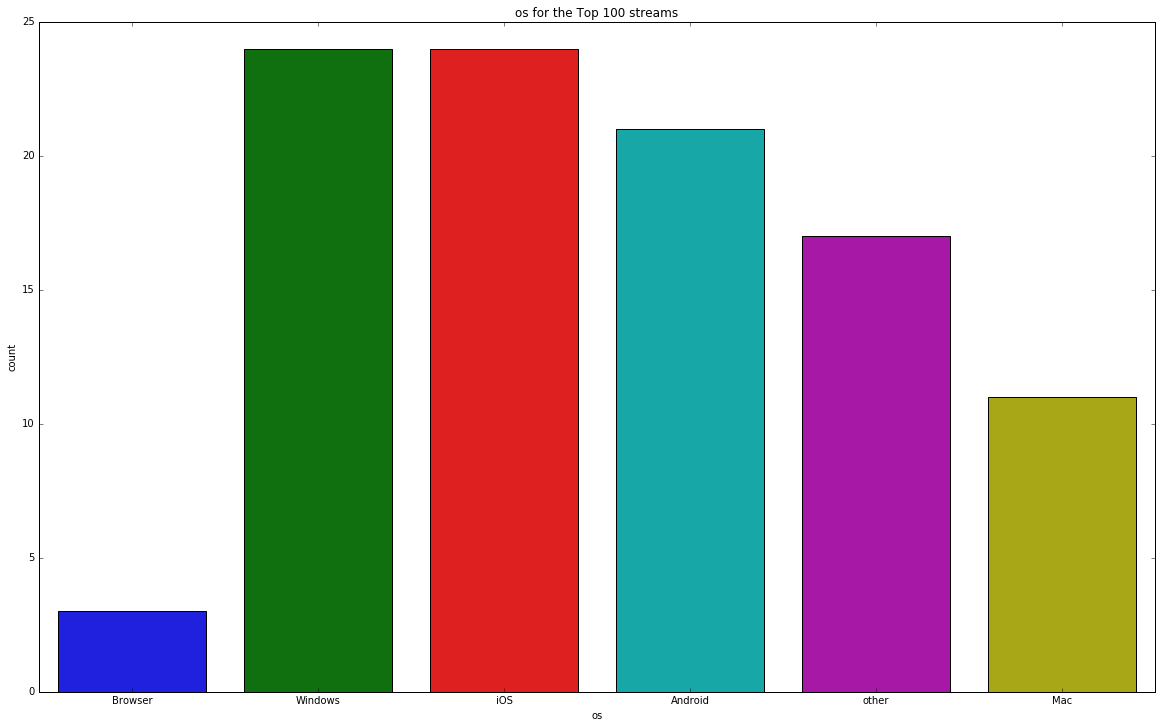

In [10]:
#First add the information on 'users' and 'tracks' to the 'streams' dataframe:
streams = pd.merge(streams, users, on='user_id')
streams = pd.merge(streams, tracks, on='track_id')

#count the number of times tracks are played by users:
stream_counts = streams.groupby(['user_id', 'track_id']).size().reset_index(name='counts')

group_by = 'os'
top_n = 100

#Find the users responsible for the top 100 streams (top meaning the higher counts of a track played by a user)
top_streams_users = stream_counts.sort_values(by='counts', ascending=False).head(100).user_id
top_streams_users_grouped = [streams[streams.user_id == u][group_by].values[0] for u in top_streams_users]

plt.figure(figsize=(20,12))
ax = sb.countplot(top_streams_users_grouped)
plt.xlabel(group_by)
plt.title('%s for the Top %s streams'%(group_by, top_n))
plt.show()

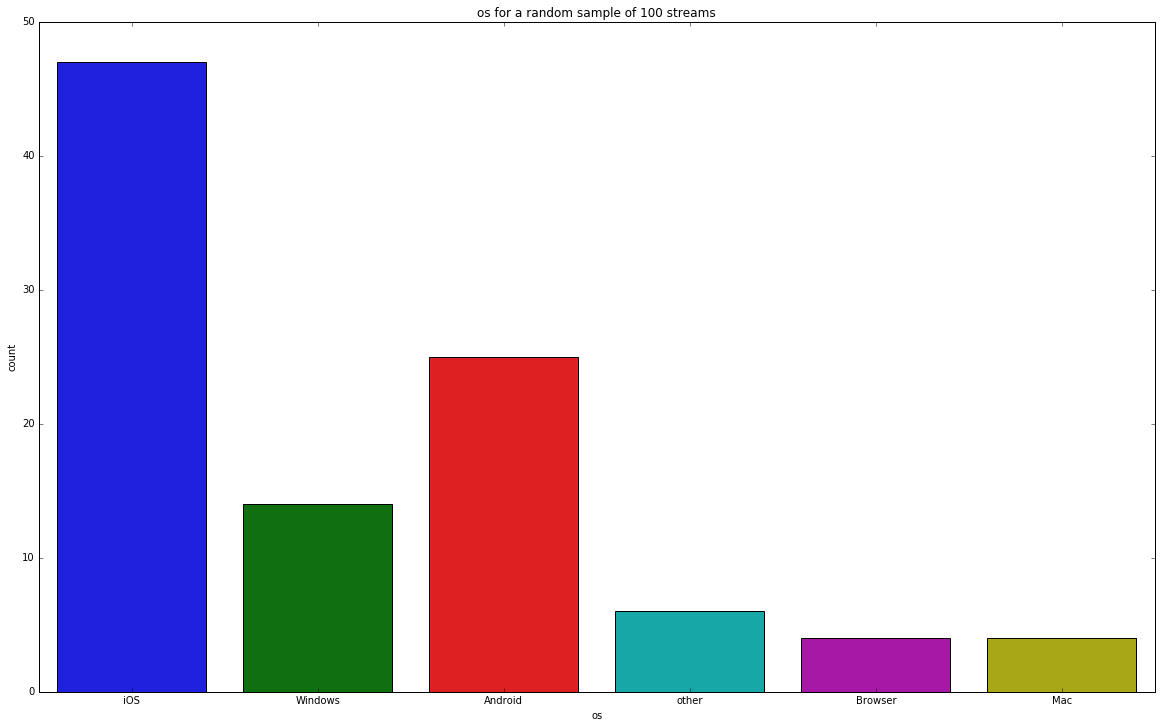

In [11]:
rand_streams_users_grouped = [streams[streams.user_id == u][group_by].values[0] for u in streams.sample(top_n).user_id]

plt.figure(figsize=(20,12))

ax = sb.countplot(rand_streams_users_grouped)
plt.xlabel(group_by)
plt.title('%s for a random sample of %s streams'%(group_by,top_n))
plt.show()
